## ADA501 - Prosjekt

In [275]:
# !pip install numpy_financial

In [276]:
import pandas as pd
import numpy as np
import sympy as sp
from collections import namedtuple
from scipy.integrate import quad
from scipy.optimize import newton
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import numpy_financial as npf
import matplotlib.pyplot as plt
from collections import namedtuple

## les inn csv filer

In [277]:
df = pd.read_excel('Siste.xlsx')
rente = pd.read_csv('datasett_KPI_Styringsrente\styringsrenten.csv', delimiter=";", decimal=",")
inflasjon1 = pd.read_csv('datasett_KPI_Styringsrente\kpi_1991_2023.csv', delimiter=";", decimal=",")
inflasjon2 = pd.read_csv('datasett_KPI_Styringsrente\KPI_månedlig_endring.csv', delimiter=";", decimal=",")


Inflasjon / rente

In [278]:
rente = rente[['TIME_PERIOD', 'OBS_VALUE']]
rente = rente.rename(columns={'TIME_PERIOD': 'Dato', 'OBS_VALUE': 'Rente'})
rente = rente.iloc[1:]

rente

,Dato,Rente
1,1991-02,8.50
2,1991-03,8.50
3,1991-04,8.48
4,1991-05,8.20
5,1991-06,8.00
...,...,...
388,2023-05,3.21
389,2023-06,3.39
390,2023-07,3.75
391,2023-08,3.86


In [279]:
# Merge 'inflasjon1' with 'inflasjon2' on 'Dato' column
inflasjon_merged = pd.merge(inflasjon1, inflasjon2, on='Dato')
inflasjon_merged['Dato'] = pd.to_datetime(inflasjon_merged['Dato'], format='%Y-%m')

# Display the merged DataFrame
inflasjon_merged

ValueError: time data 1991M02 doesn't match format specified

Oppdeling av filen i df

In [ ]:
# Filter 'Inntekt'
inntekt = df[df['Hva'] == 'Inntekt']
inntekt = inntekt.drop('Hva', axis=1)
# Filter 'Faste utgifter'
faste_utgifter = df[df['Hva'] == 'Fast utgift']
faste_utgifter = faste_utgifter.drop('Hva', axis=1)
# Filter 'Luksus'
forbruk = df[df['Hva'] == 'Luksus']
forbruk=forbruk.drop('Hva' , axis=1)

## Inntekt

Inntekt

In [ ]:
# Dato til pd_datetime & float
inntekt['Brukt'] = inntekt['Brukt'].str.replace(',', '.')
inntekt['Brukt'] = inntekt['Brukt'].astype(float)
inntekt['Dato'] = pd.to_datetime(inntekt['Dato'])

Gjør om til måendlig

In [ ]:
# Grouping the data by year and month and calculating the sum of 'Brukt' for each group
Monthly_income = inntekt.groupby(inntekt['Dato'].dt.to_period('M')).sum()

# Resetting the index to access the 'Dato' column
Monthly_income = Monthly_income.reset_index()

# Renaming the 'Dato' column to match the desired format 'YYYY-MM'
Monthly_income['Dato'] = Monthly_income['Dato'].dt.strftime('%Y-%m')

# Creating a new DataFrame named 'Monthly_income'
inntekt_måendlig = pd.DataFrame({'Dato': Monthly_income['Dato'], 'Income': Monthly_income['Brukt']})

Regression

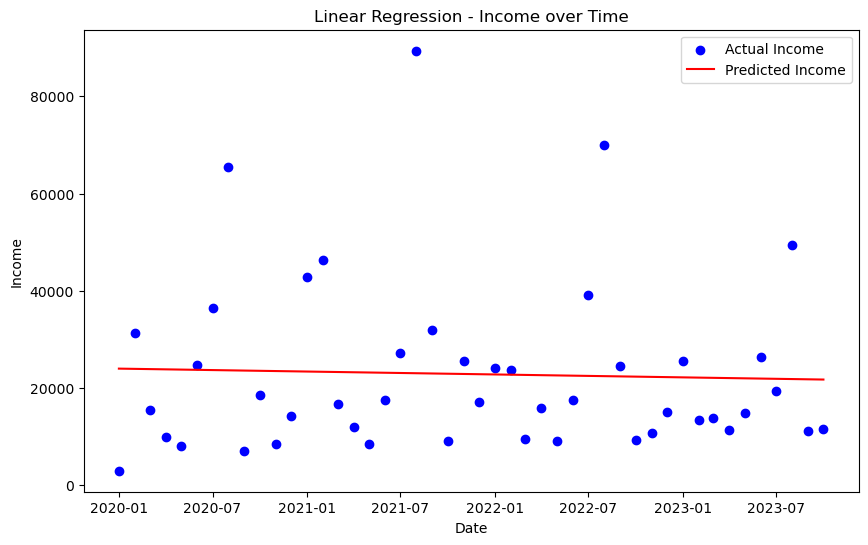

In [ ]:
# Assuming you have your data stored in måendlig_inntekt DataFrame as described previously

# Convert 'Dato' column to datetime if it's in string format
inntekt_måendlig['Dato'] = pd.to_datetime(inntekt_måendlig['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
inntekt_måendlig['Dato_numeric'] = (inntekt_måendlig['Dato'] - inntekt_måendlig['Dato'].min()).dt.days

# Define features and target variable
X_inntekt = inntekt_måendlig[['Dato_numeric']]
y_inntekt = inntekt_måendlig['Income']

# Initialize Linear Regression model
model_inntekt = LinearRegression()

# Fit the model
model_inntekt.fit(X_inntekt, y_inntekt)

# Make predictions
predictions_inntekt = model_inntekt.predict(X_inntekt)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(inntekt_måendlig['Dato'], y_inntekt, color='blue', label='Actual Income')

# Plotting the regression line
plt.plot(inntekt_måendlig['Dato'], predictions_inntekt, color='red', label='Predicted Income')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Income')
plt.title('Linear Regression - Income over Time')
plt.legend()
plt.show()


Faste utgifter

In [ ]:
faste_utgifter

,Dato,Brukt
21,2020-01-15,-1122
24,2020-01-15,-105
28,2020-01-24,-620
30,2020-02-03,-399
39,2020-02-17,-105
...,...,...
1082,2023-08-28,-229
1084,2023-08-30,-5750
1087,2023-09-01,-129
1092,2023-09-14,-5750


In [ ]:
# Dato til pd_datetime & float
faste_utgifter['Brukt'] = faste_utgifter['Brukt'].str.replace(',', '.')
faste_utgifter['Brukt'] = faste_utgifter['Brukt'].astype(float)
faste_utgifter['Dato'] = pd.to_datetime(faste_utgifter['Dato'])

In [ ]:
# Grouping the data by year and month and calculating the sum of 'Brukt' for each group
Monthly_out = faste_utgifter.groupby(faste_utgifter['Dato'].dt.to_period('M')).sum()

# Resetting the index to access the 'Dato' column
Monthly_out = Monthly_out.reset_index()

# Renaming the 'Dato' column to match the desired format 'YYYY-MM'
Monthly_out['Dato'] = Monthly_out['Dato'].dt.strftime('%Y-%m')

# Creating a new DataFrame named 'Monthly_income'
utgift_måendlig = pd.DataFrame({'Dato': Monthly_out['Dato'], 'Faste utgifter': Monthly_out['Brukt']})

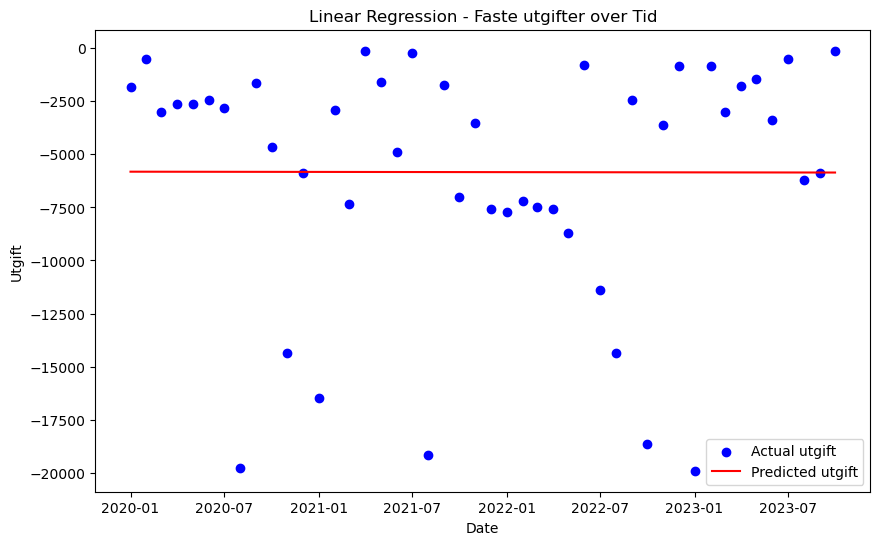

In [ ]:
# Convert 'Dato' column to datetime if it's in string format
utgift_måendlig['Dato'] = pd.to_datetime(utgift_måendlig['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
utgift_måendlig['Dato_numeric'] = (utgift_måendlig['Dato'] - utgift_måendlig['Dato'].min()).dt.days

# Define features and target variable
X_utgift = utgift_måendlig[['Dato_numeric']]
y_utgift = utgift_måendlig['Faste utgifter']

# Initialize Linear Regression model
model_utgift = LinearRegression()

# Fit the model
model_utgift.fit(X_utgift, y_utgift)

# Make predictions
predictions_utgift = model_utgift.predict(X_utgift)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(utgift_måendlig['Dato'], y_utgift, color='blue', label='Actual utgift')

# Plotting the regression line
plt.plot(utgift_måendlig['Dato'], predictions_utgift, color='red', label='Predicted utgift')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Utgift')
plt.title('Linear Regression - Faste utgifter over Tid')
plt.legend()
plt.show()

Har faste utgifter på 5750 kr i husleie nå + 4000 kr i mat, trening & mobil

Fast = 10 000 kr pr måend

Forbruk

In [ ]:
# Dato til pd_datetime & float
forbruk['Brukt'] = forbruk['Brukt'].str.replace(',', '.')
forbruk['Brukt'] = forbruk['Brukt'].astype(float)
forbruk['Dato'] = pd.to_datetime(forbruk['Dato'])

In [ ]:
# Grouping the data by year and month and calculating the sum of 'Brukt' for each group
Monthly_forbruk = forbruk.groupby(forbruk['Dato'].dt.to_period('M')).sum()

# Resetting the index to access the 'Dato' column
Monthly_forbruk = Monthly_forbruk.reset_index()

# Renaming the 'Dato' column to match the desired format 'YYYY-MM'
Monthly_forbruk['Dato'] = Monthly_forbruk['Dato'].dt.strftime('%Y-%m')

# Creating a new DataFrame named 'Monthly_income'
forbruk_måendlig = pd.DataFrame({'Dato': Monthly_forbruk['Dato'], 'Forbruk': Monthly_forbruk['Brukt']})

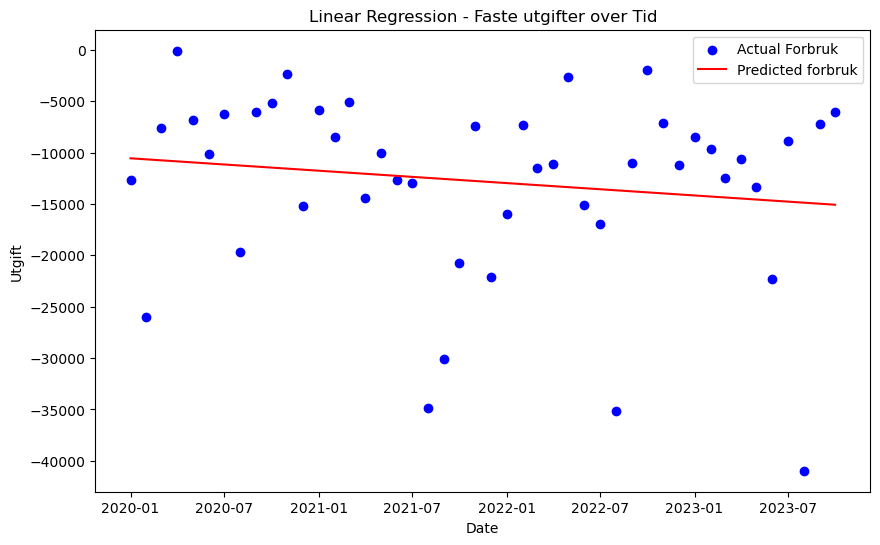

In [ ]:
# Convert 'Dato' column to datetime if it's in string format
forbruk_måendlig['Dato'] = pd.to_datetime(forbruk_måendlig['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
forbruk_måendlig['Dato_numeric'] = (forbruk_måendlig['Dato'] - forbruk_måendlig['Dato'].min()).dt.days

# Define features and target variable
X_forbruk = forbruk_måendlig[['Dato_numeric']]
y_forbruk = forbruk_måendlig['Forbruk']

# Initialize Linear Regression model
model_forbruk = LinearRegression()

# Fit the model
model_forbruk.fit(X_forbruk, y_forbruk)

# Make predictions
predictions_forbruk = model_forbruk.predict(X_forbruk)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(forbruk_måendlig['Dato'], y_forbruk, color='blue', label='Actual Forbruk')

# Plotting the regression line
plt.plot(forbruk_måendlig['Dato'], predictions_forbruk, color='red', label='Predicted forbruk')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Utgift')
plt.title('Linear Regression - Faste utgifter over Tid')
plt.legend()
plt.show()

ODE

Initialisering av varaibler

In [ ]:
I0 = predictions_inntekt[-1]        # Startinntekt pr måend
U0 = predictions_utgift[-1]         # Faste utgifter
F0 = predictions_forbruk[-1]        # Initiale forbruksvaner
R0 = rente['Rente'].iloc[-1]        # Startboliglånsrenterente
S0 = 0                              # Ønsker å starte med 0 kr i overskudd, men fast inntekt
S0 = 300000                         # Startsluttresultat over 25 år, vil ha et overskudd på konto

In [ ]:
k1 = 0.8        # Økning i forbruk etter inntekt                    -> hurtig økning etter inntektsøkning
k2 = 0.7        # Reduksjon i forbruk etter inntekt                 -> sakte endring etter inntektsfall
k3 = 0.3        # Renteendring basert på forbruk                    -> Forbruk øker -> Renter øker  -> Lånet påvirkes -> Må bruke mindre penger
k4 = 0.025      # Endring i inflasjon basert på forbuk & rente      -> Endres 0,25 poeng oftest

In [ ]:
t0 = 0
t1 = 25

# Definer tidsintervall og initialverdier
t = np.linspace(t0, t1, 1000)
y0 = [I0, U0, F0, R0]

Inntekt de neste 25 årene - første 2 årene etter regression line, også etter 2 år, så hopper til 50 000 kr i måend

In [ ]:
# Define time for 25 periods (years)
future_time = np.array(range(1, t1 + 1)).reshape(-1, 1)  # Creating an array from 1 to 25 for future time

c:\Users\even\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


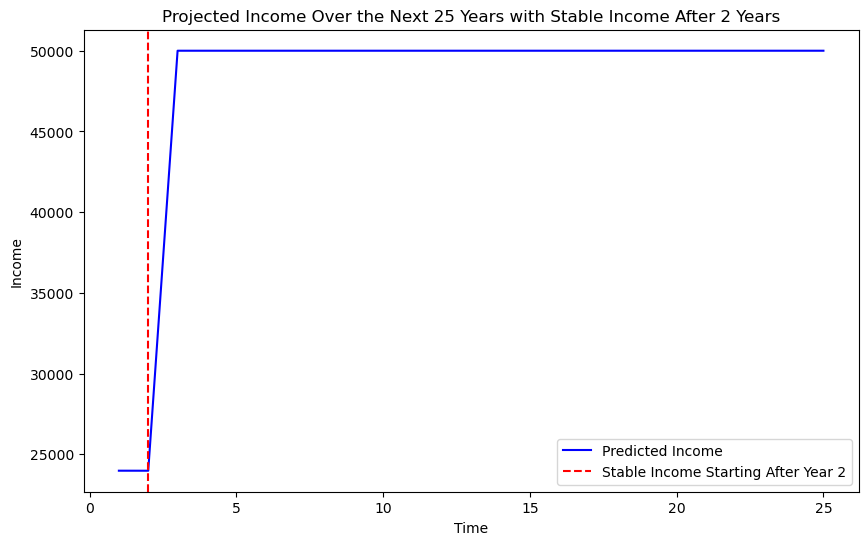

In [ ]:
# Predicting income for the next 25 years using the model
predicted_income_future = model_inntekt.predict(future_time)

# Modify the predicted income values after the second year
change_index = 2  # Index for the third year
stable_income = 50000  # Stable income value

# Apply the change in income prediction
predicted_income_future[change_index:] = stable_income

# Plotting the future predictions with adjusted income after the second year
plt.figure(figsize=(10, 6))
plt.plot(future_time, predicted_income_future, color='blue', label='Predicted Income')

plt.xlabel('Time')
plt.ylabel('Income')
plt.title('Projected Income Over the Next 25 Years with Stable Income After 2 Years')
plt.axvline(x=2, color='red', linestyle='--', label='Stable Income Starting After Year 2')
plt.legend()
plt.show()

Faste utgifter

c:\Users\even\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


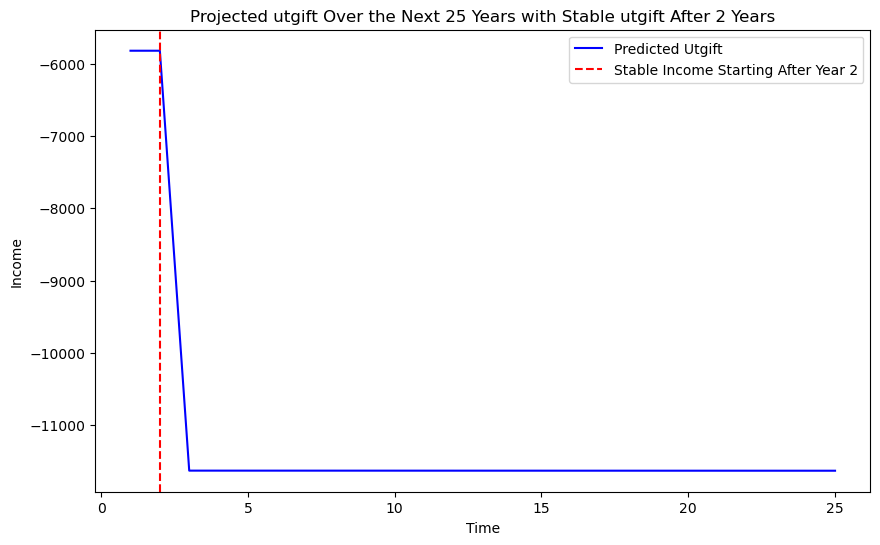

In [ ]:
# Predicting income for the next 25 years using the model
predicted_utgift_future = model_utgift.predict(future_time)

# Modify the predicted income values after the second year
change_index = 2  # Index for the third year
change_factor = 2  # Adjust income by a factor of 1.2 (120%)

# Apply the change in income prediction
predicted_utgift_future[change_index:] *= change_factor

# Plotting the future predictions with adjusted income after the second year
plt.figure(figsize=(10, 6))
plt.plot(future_time, predicted_utgift_future, color='blue', label='Predicted Utgift')

plt.xlabel('Time')
plt.ylabel('Income')
plt.title('Projected utgift Over the Next 25 Years with Stable utgift After 2 Years')
plt.axvline(x=2, color='red', linestyle='--', label='Stable Income Starting After Year 2')
plt.legend()
plt.show()

Forbruk

c:\Users\even\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


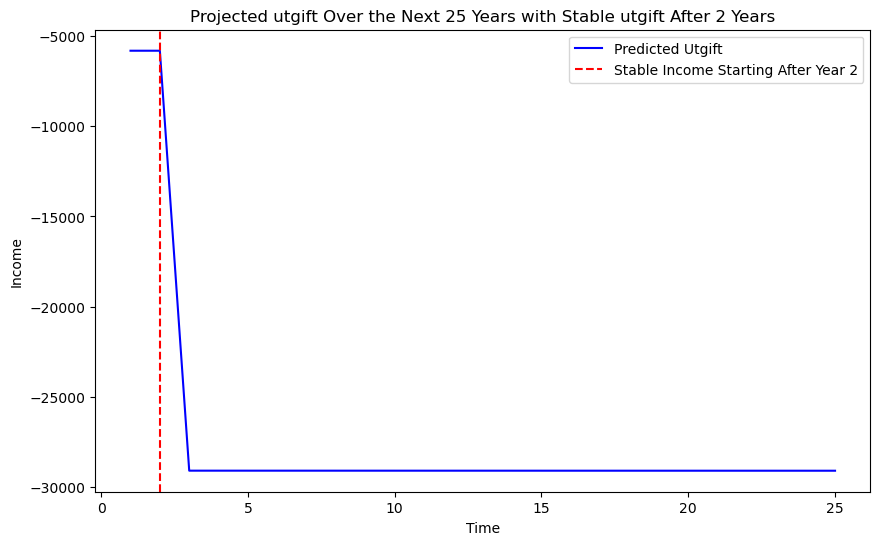

In [ ]:
# Predicting income for the next 25 years using the model
predicted_forbruk_future = model_forbruk.predict(future_time)

# Modify the predicted income values after the second year
change_index = 2  # Index for the third year
change_factor = 2.5  # Adjust income by a factor of 1.2 (120%)

# Apply the change in income prediction
predicted_utgift_future[change_index:] *= change_factor

# Plotting the future predictions with adjusted income after the second year
plt.figure(figsize=(10, 6))
plt.plot(future_time, predicted_utgift_future, color='blue', label='Predicted Utgift')

plt.xlabel('Time')
plt.ylabel('Income')
plt.title('Projected utgift Over the Next 25 Years with Stable utgift After 2 Years')
plt.axvline(x=2, color='red', linestyle='--', label='Stable Income Starting After Year 2')
plt.legend()
plt.show()

Forbruk ODE

In [ ]:
def forbruk_model(t, forbruk, inntekt, faste_utgifter, k1, k2):
   d_forbruk_dt = k1 * (inntekt - faste_utgifter) - (k2 * forbruk)
   return d_forbruk_dt

In [ ]:
def rente(rente, inflation): 
    target_inflation = 2.5  # Target inflation rate

    # Calculate the change in inflation based on the current inflation rate
    if inflation < target_inflation:  # If inflation is below target - 0.25%
        change = -0.025
    elif inflation > target_inflation:  # If inflation is above target + 0.25%
        change = 0.025
    else:  # Inflation is within the range of target -0.25% to target +0.25%
        change = 0  # No change

    # Update the inflation rate considering the change
    new_inflation = inflation + change

    # Return the new inflation rate
    return new_inflation

In [ ]:
def inflasjon(t, inflation, economic_factors, target_rate):
    adjustment = k4 * (economic_factors - target_rate)
    return adjustment

## Ønsket lån

In [ ]:
startKapital = 0    # startkapitalen
terminer = 300      # 12 terminer over 25 år

Serielån

Annuitetslån